# Introduction

## Goals

* Measure the numerical precision of [fmriprep](https://github.com/nipreps/fmriprep)

## Methods

* Processed session `ses-001` of subject `sub-adult16` from `openneuro` [ds001748](https://openneuro.org/datasets/ds001748/versions/1.0.4)
* fmriprep options:
`--output-spaces MNI152NLin2009cAsym MNI152NLin6Asym \
 --notrack --write-graph --resource-monitor \
 --omp-nthreads 1 --nprocs 1 --mem_mb 65536 \
 --random-seed 0`
* fmriprep container 20.2.1lts

In [1]:
import numpy as np
import nibabel as nib
import os
import glob
import re
import subprocess
import IPython.display
import ffmpeg

from nilearn import plotting as nilp
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
independent_anat_func = False
n_samples = 5
sampling = "ieee"
dataset = "ds001748"
participant = "sub-adult16"
output_template = "MNI152NLin2009cAsym"

In [3]:
# input directories
input_dir = os.path.join(os.getcwd(), "..", "..", "outputs", "ieee")
if independent_anat_func:
    input_dir = os.path.join(input_dir, "fmriprep_{dataset}_{ii}_{scan}", "fmriprep", "{participant}", "{scan}")
else:
    input_dir = os.path.join(input_dir, "fmriprep_{dataset}_{ii}", "fmriprep", "{participant}", "{scan}")
glob_anat_path = os.path.join(input_dir, f"*{output_template}_desc-preproc_T1w.nii.gz")
glob_func_path = os.path.join(input_dir, "*_task-{task}_" + f"*{output_template}_desc-preproc_bold.nii.gz")
glob_mask_path = os.path.join(input_dir, f"*{output_template}_desc-brain_mask.nii.gz")
glob_func_mask_path = os.path.join(input_dir, "*_task-{task}_" + f"*{output_template}_desc-brain_mask.nii.gz")
glob_seg_wm_path = os.path.join(input_dir, f"*{output_template}_label-WM_probseg.nii.gz")
glob_seg_gm_path = os.path.join(input_dir, f"*{output_template}_label-GM_probseg.nii.gz")
glob_seg_csf_path = os.path.join(input_dir, f"*{output_template}_label-CSF_probseg.nii.gz")
# report outputs
output_dir = os.path.join(os.getcwd(), "..", "..", "outputs")
output_dir = os.path.join(output_dir, "{sampling}", "stability_report_{dataset}", "{participant}")
gif_dir = output_dir.format(sampling=sampling, dataset=dataset, participant=participant)

In [4]:
# From https://raw.githubusercontent.com/gkpapers/2020AggregateMCA/master/code/utils.py
def sigdig(array, base=2, axis=-1):
    '''
    Compute significant digits of array elements along axis
    '''
    try:
        # If we have a float, this is our value of epsilon
        eps = np.finfo(array.dtype).eps
    except ValueError:
        # If it's an int, we want to convert it to a float of the same number of
        # bits to get our estimate of epsilon
        a2_dtype = "np.float{0}".format(array.dtype.itemsize*8)
        a2 = array.astype(eval(a2_dtype))
        warnings.warn("Converting array from {} to {}".format(array.dtype,
                                                              a2.dtype),
                      Warning)
        # Re-call the function with the float version
        return sigdig(a2, base=base, axis=axis)

    # Initialize empty matrix the same size of the array
    shp = list(array.shape)
    shp.pop(axis)
    sigs = np.empty(shp)
    sigs[:] = np.NaN

    # Compute the standard deviation and handle special case 1:
    #   - if no variance, maximum significance
    sd = np.std(array, axis=axis)
    c1locs = np.where(sd == 0)
    sigs[c1locs] = -np.log(eps)/np.log(base)

    # Compute the mean and handle special case 2:
    #   - if mean of 0, no significance.
    #   - N.B. this is the incorrect formula for zero-centered data
    mn = np.mean(array, axis=axis)
    c2locs = np.where(mn == 0)
    for c2l in zip(*c2locs):
        if np.isnan(sigs[c2l]):
            sigs[c2l] = 0

    # Otherwise, compute the number of significant digits using Parker, 1997
    c3locs = np.where(np.isnan(sigs))
    for c3l in zip(*c3locs):
        sigs[c3l] = -np.log(np.abs(sd[c3l] / mn[c3l]) + eps)/np.log(base)

    # Reset any negative values to zero
    c4l = np.where(sigs <= 0)
    sigs[c4l] = 0

    # Round up to nearest full bit, and return
    sigs = np.ceil(sigs).astype(int)
    return sigs

In [5]:
# plotting utility
def plot_array(array, affine, cmap=mpl.cm.viridis):
    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 8))
    ni_img = nib.Nifti1Image(array, affine)

    #fig.suptitle("(b) Distributions of significant bits averaged among 20 subjects on MNI space", fontsize=14)
    nilp.plot_img(ni_img, draw_cross=False, cmap=cmap, axes=axes, annotate=False, black_bg=False, colorbar=True, cut_coords=(0, 0, 0))

In [6]:
def view_sig_dig(array, mask, affine, participant="sub-0000", dataset="ds00000", category="raw", task=""):  
    # Get significant digits and extract mean
    sigdigs = sigdig(array, base=10, axis=0)
    mean_sigdig = np.mean(sigdigs[mask])
    print("The average number of significant digits for {category} {sub} {task} in {ds} is {sd:.3f} on a scale of 16 (higher means less difference).".format(
        sub=participant
        , ds=dataset
        , sd=mean_sigdig
        , category=category
        , task=task))
    # Plot masked sigdigits
    masked_sigdigs = np.where(mask, sigdigs, np.min(sigdigs))
    ni_img = nib.Nifti1Image(masked_sigdigs, affine)
    
    return nilp.view_img(ni_img
                         , cmap=mpl.cm.viridis
                         , symmetric_cmap=False
                         , bg_img=False
                         , black_bg=True
                         , cut_coords=(0, 0, 0)
                         , title="{ds}_{sub} {task} {category}".format(ds=dataset, sub=participant, category=category, task=task))

In [7]:
def plot_visual_diff(array, mask, affine, gif_dir="./", participant="sub-0000", dataset="ds00000", category="raw"):
    n_samples = array.shape[0]
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)
    for ii in range(n_samples):
            masked_img = np.where(mask, array[ii], np.min(array[ii]))
            ni_img = nib.Nifti1Image(masked_img, affine)
            display = nilp.plot_img(ni_img
                                    , cmap="gray"
                                    , draw_cross=False
                                    , cut_coords=(0, 0, 0)
                                    , black_bg=True
                                    , title="{ds}_{sub} {category}".format(ds=dataset, sub=participant, category=category))
            display.savefig('{gif_dir}/{category}_{ii:03d}.png'.format(gif_dir=gif_dir, ii=ii, category=category))
            display.close()

    process = subprocess.Popen(["ffmpeg"
                                , "-framerate"
                                , "5"
                                , "-y"
                                , "-i"
                                , f"{gif_dir}/{category}_%03d.png"
                                , f"{gif_dir}/{category}_visual_diff.gif"
                               ], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(process.stdout.read().decode("utf-8"))
    return IPython.display.display(IPython.display.Image(filename=f"{gif_dir}/{category}_visual_diff.gif", embed=True))

In [8]:
def histogram(array):
    diff = []
    
    for ii in range(array.shape[0]):
        for jj in np.arange(ii+1, array.shape[0]):
            curr_diff = (array[ii] - array[jj]).flatten()
            diff += [curr_diff]
    diff = np.array(diff).flatten()
    mean = np.mean(diff)
    std = np.std(diff)
    # plotting
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    plt.yscale('log')
    plt.hist(diff, bins=50, density=True)
    plt.title("mean: {:.3f}; std: {:.3f}".format(str(mean), str(std)))

# Anatomical

In [9]:
scan = "anat"

In [10]:
# Read image and mask files
image_files = []
mask_files = []
seg_wm_files = []
seg_gm_files = []
seg_csf_files = []
masks = []
images = []
wm_segs = []
gm_segs = []
csf_segs = []
for i in range(n_samples):
    # filenames
    mask_file = glob.glob(glob_mask_path.format(sampling=sampling, dataset=dataset, ii=i+1, participant=participant, scan=scan))[0]
    image_file = glob.glob(glob_anat_path.format(sampling=sampling, dataset=dataset, ii=i+1, participant=participant, scan=scan))[0]
    seg_wm_file = glob.glob(glob_seg_wm_path.format(sampling=sampling, dataset=dataset, ii=i+1, participant=participant, scan=scan))[0]
    seg_gm_file = glob.glob(glob_seg_gm_path.format(sampling=sampling, dataset=dataset, ii=i+1, participant=participant, scan=scan))[0]
    seg_csf_file = glob.glob(glob_seg_csf_path.format(sampling=sampling, dataset=dataset, ii=i+1, participant=participant, scan=scan))[0]
    image_files += [image_file]
    mask_files += [mask_file]
    seg_wm_files += [seg_wm_file]
    seg_gm_files += [seg_gm_file]
    seg_csf_files += [seg_gm_file]
    # mask loading
    masks += [nib.load(mask_file).get_fdata().astype('bool')]
    # segmentation files
    wm_segs += [nib.load(seg_wm_file).get_fdata()]
    gm_segs += [nib.load(seg_gm_file).get_fdata()]
    csf_segs += [nib.load(seg_csf_file).get_fdata()]
    # image loading
    nib_img = nib.load(image_file)
    images += [nib_img.get_fdata()]

masks = np.array(masks)
final_mask = np.array(np.prod(np.float32(masks), axis=0), dtype=np.bool)
images = np.array(images)
wm_segs = np.array(wm_segs)
gm_segs = np.array(gm_segs)
csf_segs = np.array(csf_segs)
# affines (should be identical for each category)
affine = nib_img.affine

## Raw differences
### Significant digits

Using the functions defined above, we can now compute the number of significant digits in the images normalized to the MNI template.

The average number of significant digits for raw sub-adult16  in ds001748 is 3.006 on a scale of 16 (higher means less difference).



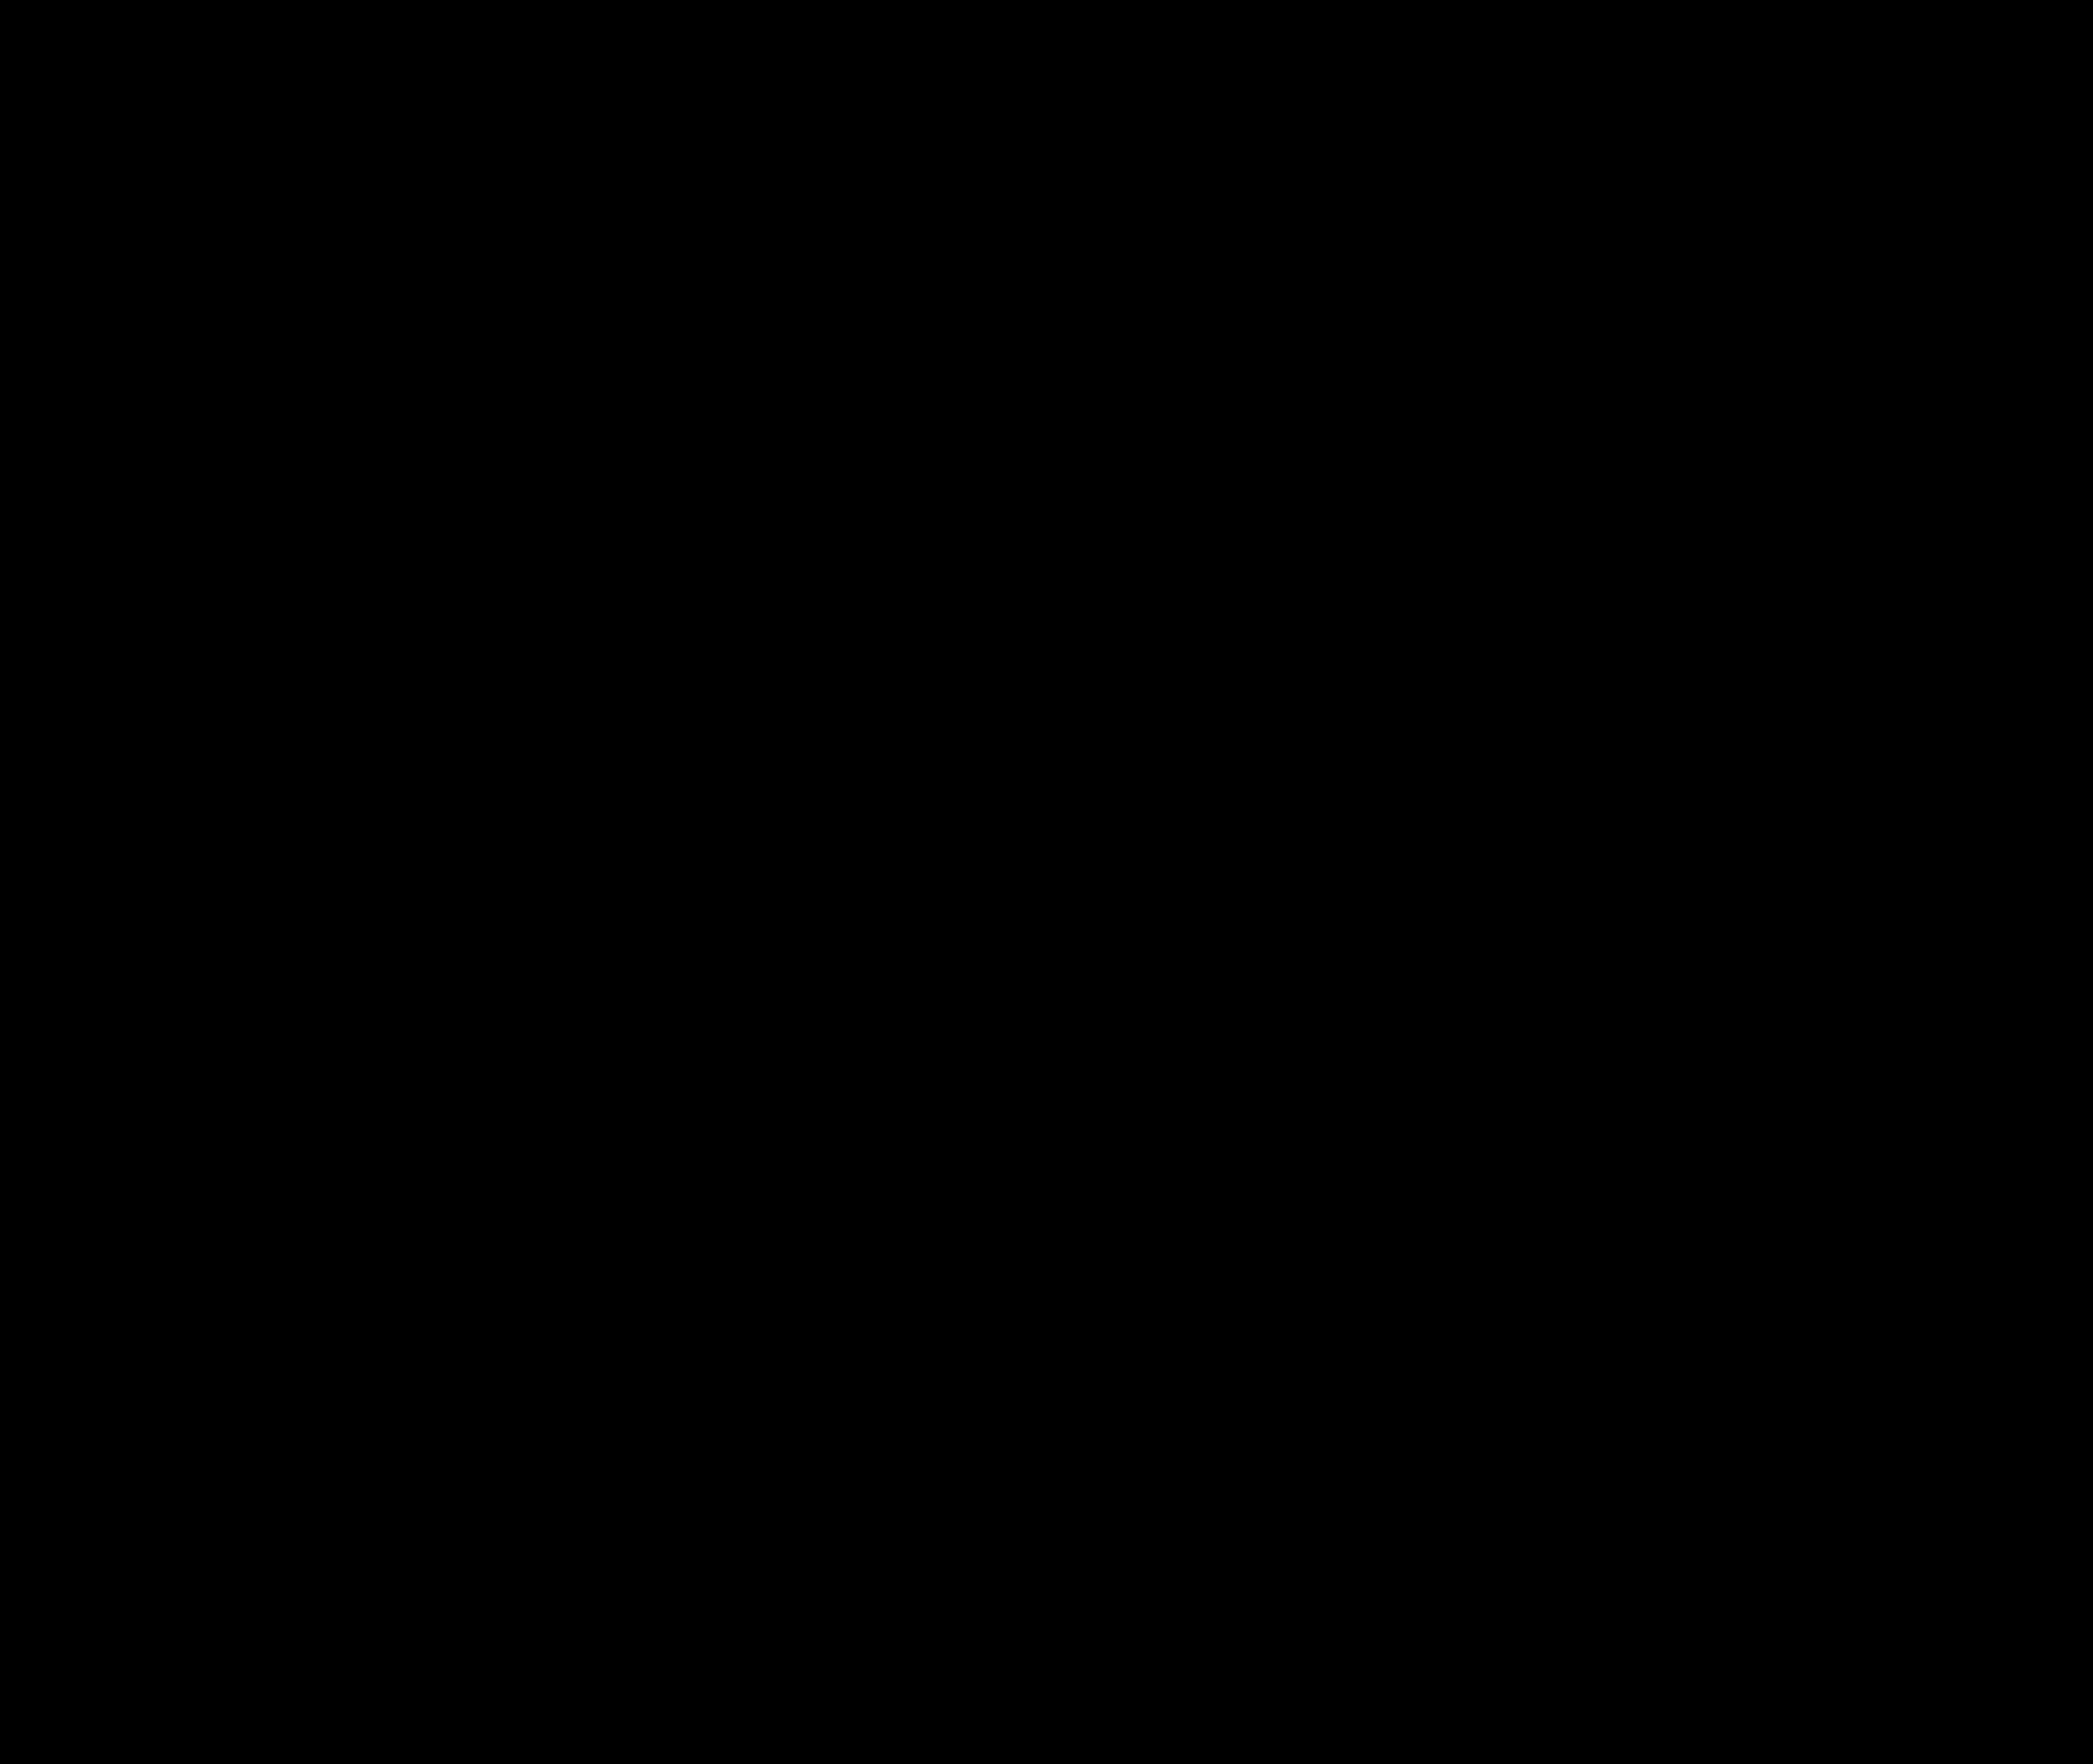
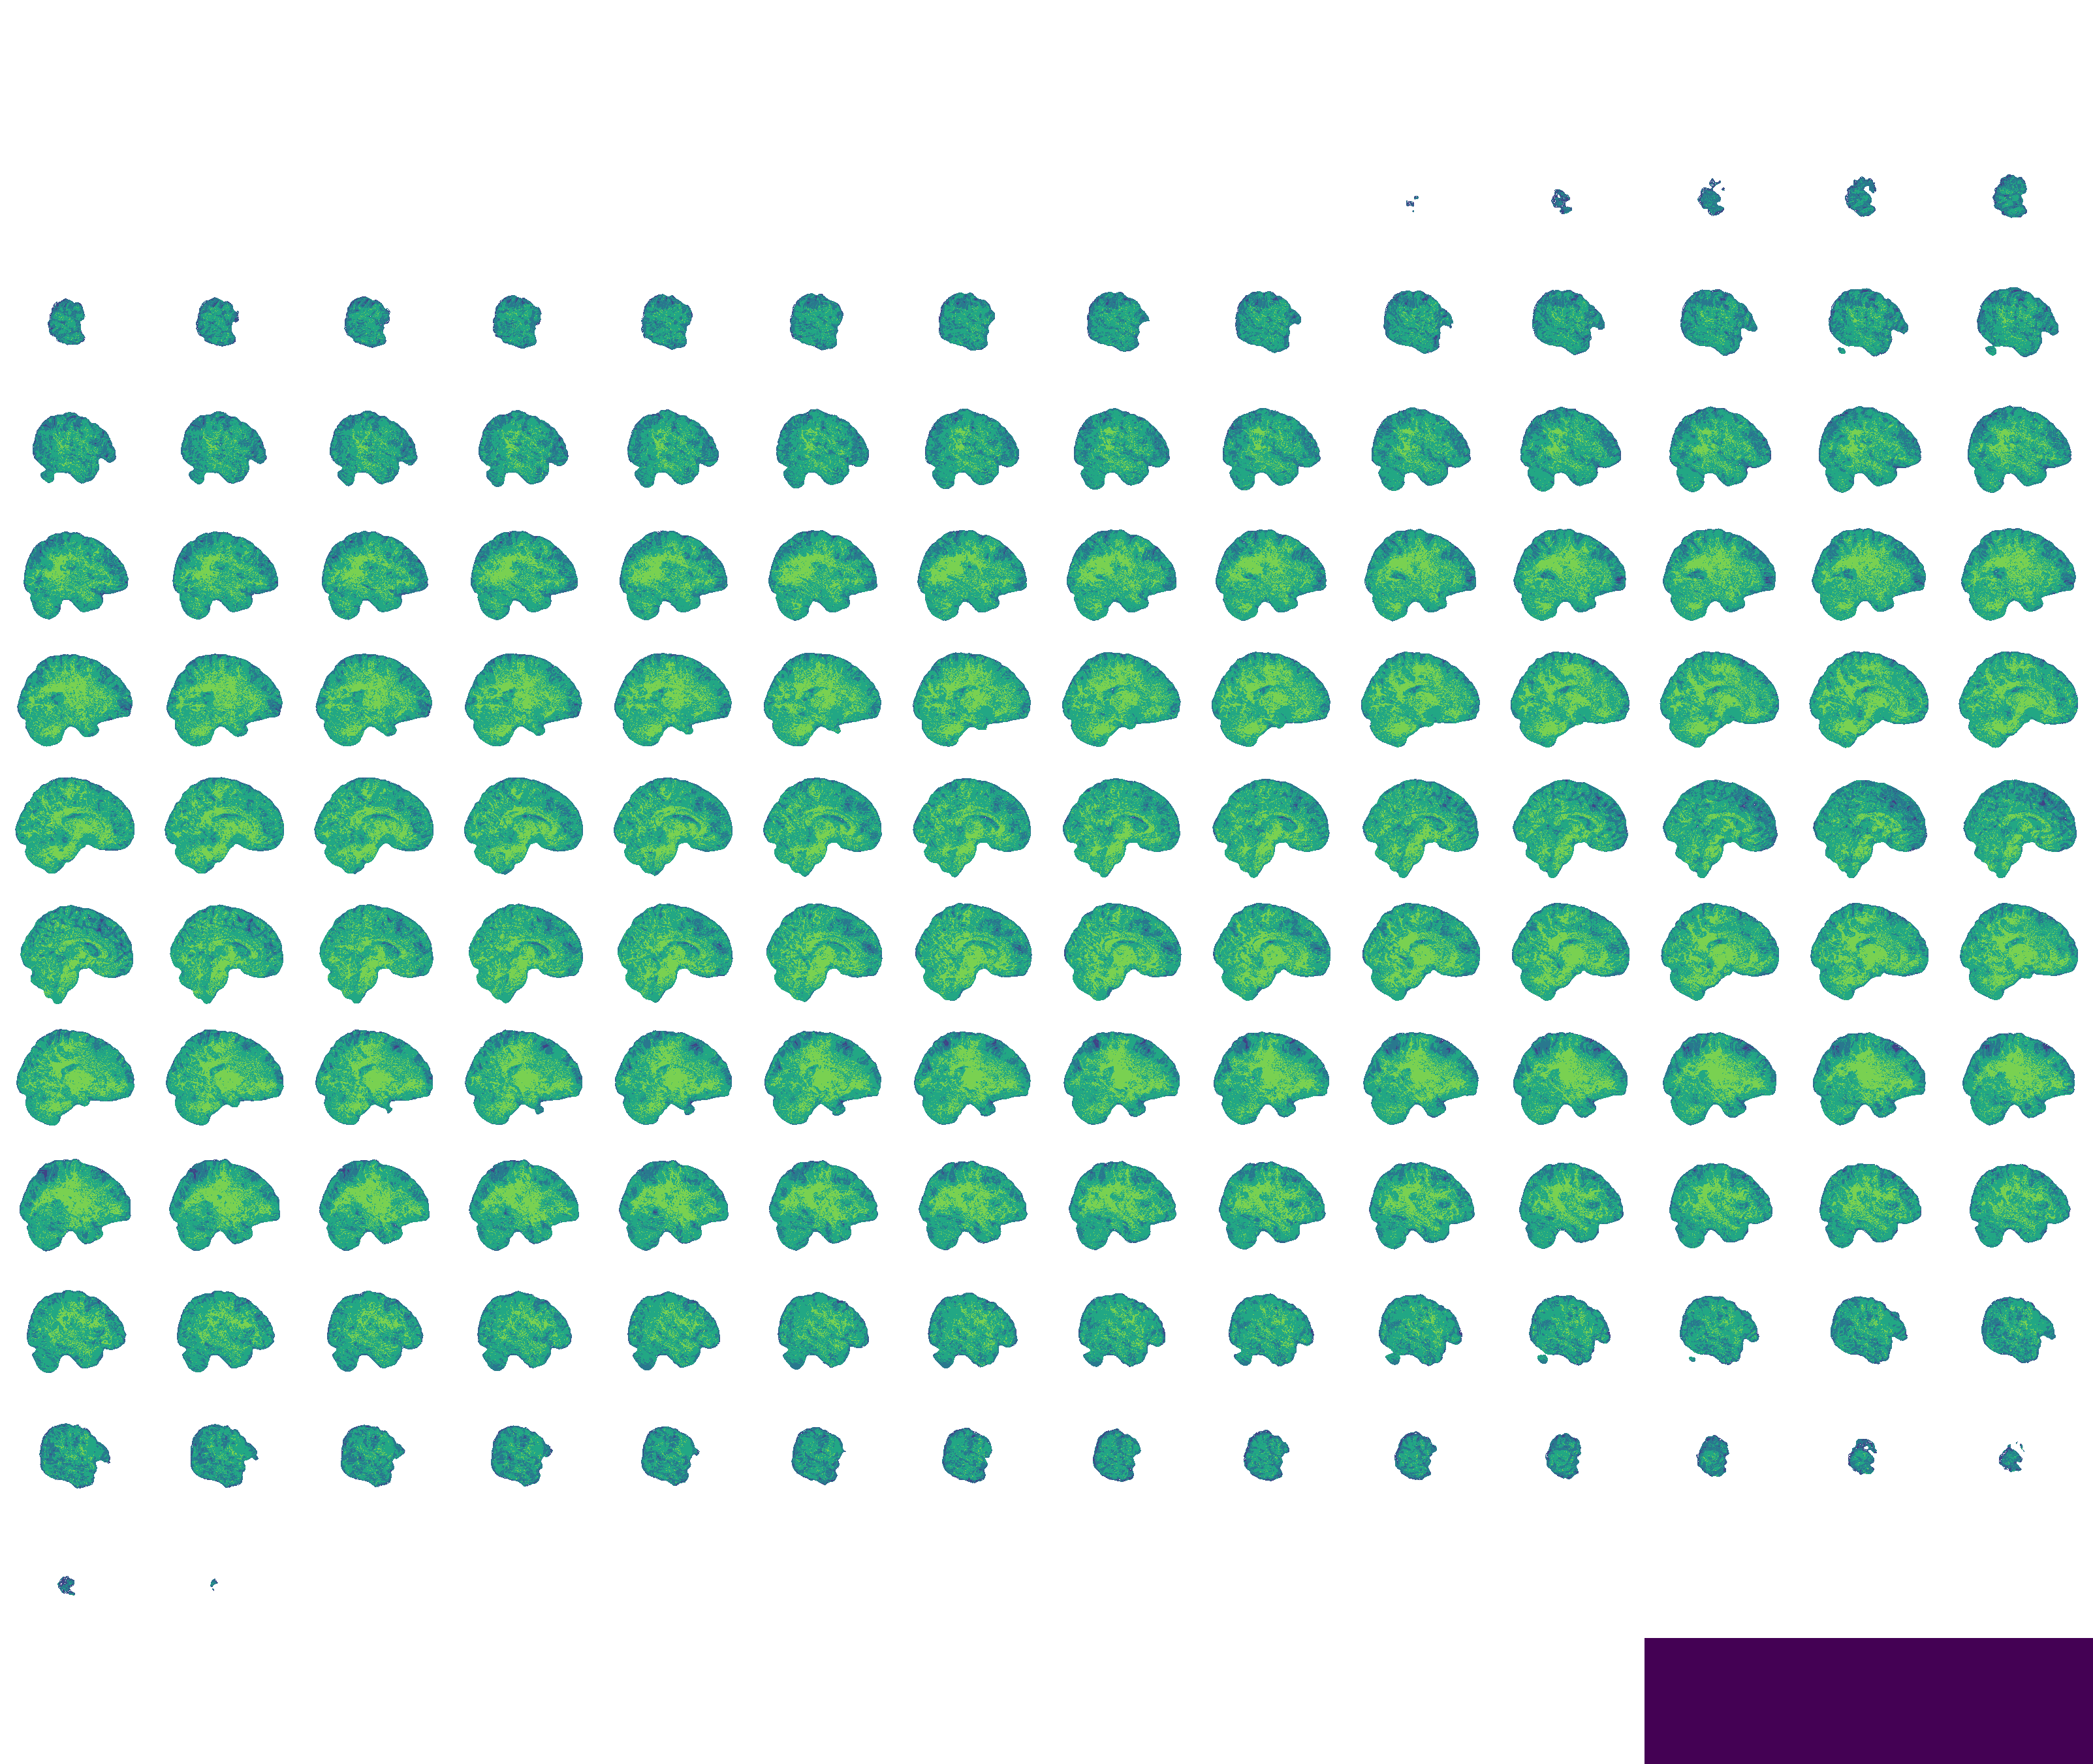

In [11]:
parameters = dict(category="raw", participant=participant, dataset=dataset)
view_sig_dig(images, final_mask, affine, **parameters)

### Visual differences

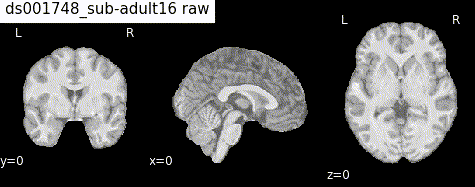

In [12]:
plot_visual_diff(images, final_mask, affine, gif_dir=gif_dir, **parameters)
IPython.display.HTML("<img src=\"{gif_dir}/{category}_visual_diff.gif\">".format(gif_dir=gif_dir, category=parameters["category"]))

### Statistical distribution

ValueError: Unknown format code 'f' for object of type 'str'

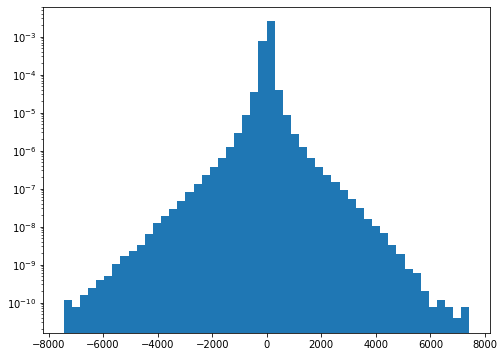

In [13]:
histogram(images)

## Tissue class probabilities
## White matter

### Significant digits

In [ ]:
parameters = dict(category="wm", participant=participant, dataset=dataset)
view_sig_dig(wm_segs, final_mask, affine, **parameters)

### Visual differences

In [ ]:
plot_visual_diff(wm_segs, final_mask, affine, gif_dir=gif_dir, **parameters)
IPython.display.HTML("<img src=\"{gif_dir}/{category}_visual_diff.gif\">".format(gif_dir=gif_dir, category=parameters["category"]))

### Statistical distribution

In [ ]:
histogram(wm_segs)

## Gray matter

### Significant digits

In [ ]:
parameters = dict(category="gm", participant=participant, dataset=dataset)
view_sig_dig(gm_segs, final_mask, affine, **parameters)

### Visual differences

In [ ]:
plot_visual_diff(gm_segs, final_mask, affine, gif_dir=gif_dir, **parameters)
IPython.display.HTML("<img src=\"{gif_dir}/{category}_visual_diff.gif\">".format(gif_dir=gif_dir, category=parameters["category"]))

### Statistical distribution

In [ ]:
histogram(gm_segs)

## Cerebrospinal Fluid

### Significant digits

In [ ]:
parameters = dict(category="csf", participant=participant, dataset=dataset)
view_sig_dig(csf_segs, final_mask, affine, **parameters)

### Visual differences

In [ ]:
plot_visual_diff(csf_segs, final_mask, affine, gif_dir=gif_dir, **parameters)
IPython.display.HTML("<img src=\"{gif_dir}/{category}_visual_diff.gif\">".format(gif_dir=gif_dir, category=parameters["category"]))

### Statistical distribution

In [ ]:
histogram(csf_segs)

# Functionnal

In [ ]:
scan = "func"

In [ ]:
# Get tasks name
list_tasks = []
func_by_task = glob.glob(glob_func_path.format(sampling=sampling, dataset=dataset, ii=1, participant=participant, scan=scan, task="*"))
for fpath in func_by_task:
    task = re.search(".*?task-(.*?)_space.*?", fpath)[1]
    if task:
        list_tasks += [task]

## Raw differences
### Statistical distribution

In [ ]:
# For each task
for task in list_tasks:
    func_images = []
    func_masks = []
    for ii in range(n_samples):
        # filenames
        func_task = glob.glob(glob_func_path.format(sampling=sampling, dataset=dataset, ii=ii+1, participant=participant, scan=scan, task=task))[0]
        glob_func_mask_path = glob.glob(glob_func_path.format(sampling=sampling, dataset=dataset, ii=ii+1, participant=participant, scan=scan, task=task))[0]
        # mask loading
#         func_masks += [nib.load(mask_file).get_fdata().astype('bool')]
        # image loading
        nib_img = nib.load(func_task)
        func_images += [nib_img.get_fdata()[..., ::5]]
#     func_masks = np.array(func_masks)
#     final_func_mask = np.array(np.prod(np.float32(func_masks), axis=0), dtype=np.bool)
    func_images = np.array(func_images)
    histogram(func_images)
    
#     parameters = dict(category="raw", participant=participant, dataset=dataset)
#     view_sig_dig(func_images, final_func_mask, affine, **parameters)